# Content

In this notebook we detail the technique for automatically detecting outer-iterations.
This can be done by a simple cross-correlation (as done for the paper) but combining this with some signal processing techniques the computations can be really faster and we think it is worth using them.

# Imports and Globals

Here are the python packages that must be available to run the script.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, sosfiltfilt, butter
from tools import pearson_xcorr

Below are the global path variables where are stored curves and pre-computed data (from other notebooks).
Please adapt to your personnal installation.

In [2]:
# adapt here the pathes to your configuration (be sure directories exist)
curve_directory = '../data'
tmp_directory = './tmp'
curve_filename  = 'bike_cortexm4_20_traces.npy'

# A First Glance at Outer-Iterations

In [3]:
curves = np.load(os.path.join(curve_directory,curve_filename))[:20]
mean_curve_full = np.mean(curves,axis=0)

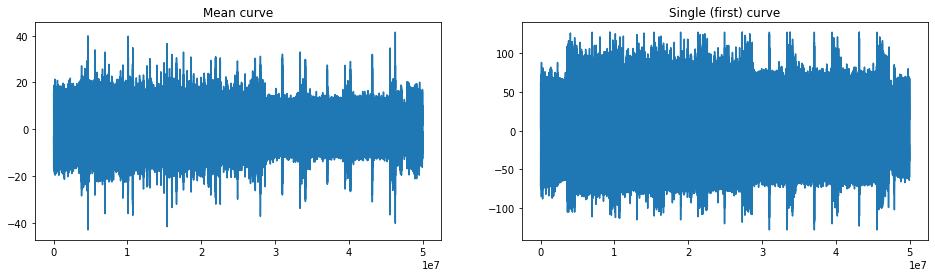

In [4]:
fig,axes = plt.subplots(1,2,figsize=[16,4])
axes[0].plot(mean_curve_full)
axes[0].set_title("Mean curve")
axes[1].plot(curves[0])
axes[1].set_title("Single (first) curve")
plt.show()

We can observe some particular patterns in the second half of the curve.
The fact is that the decoding algorithm uses 7 iterations to reach a zero syndrome but it turns out that the 3 last are useless in an overwelming proportion of the traces.
Indeed, once the syndrome vanishes, all operations on it will leak far less and this is why we have such singular patterns where roughly part of the computations just seems to disappear.

Let us make some rough delimitation of those 7 outer iterations.

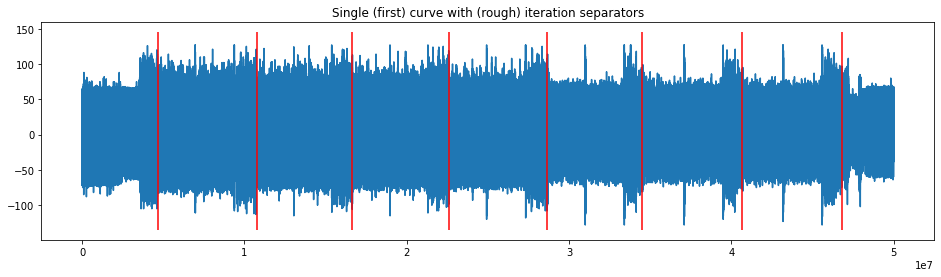

In [5]:
rough_outer_starts = [4680000,10750000,16650000,22600000,28670000,34520000,40640000,46840000]
fig = plt.figure(figsize=[16,4])
ax = fig.gca()
ax.plot(curves[0])
ax.vlines(rough_outer_starts, ymin=-135, ymax=145, color='red')
ax.set_title("Single (first) curve with (rough) iteration separators")
plt.show()

As one can see, the patterns corresponding to a non-zero syndrome strongly differ from the one with a zero syndrome. 


# Prelude Pattern to Outer-Iterations

We can see that before each outer iteration starts there is a *big pattern*.
We manually adjust our rough estimates `rough_outer_starts` on some outer iterations of the first curve to plot the corresponding *big patterns*.

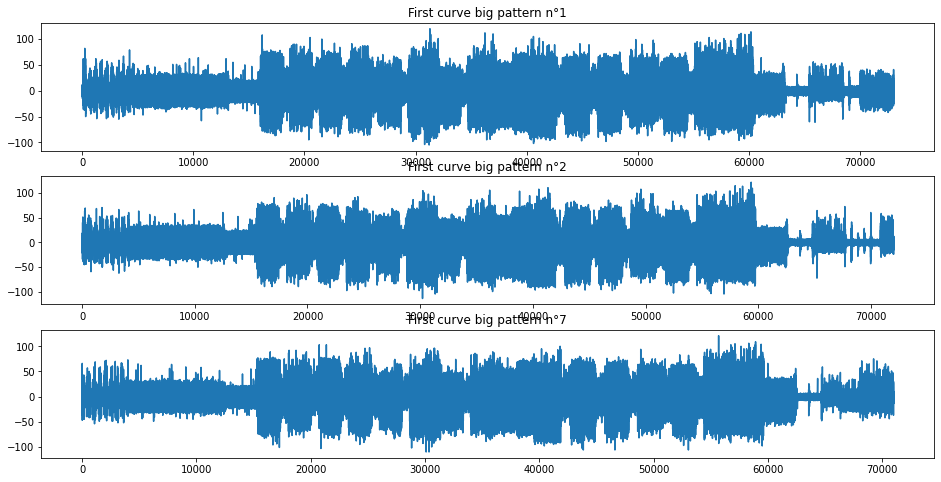

In [6]:
fig, axes = plt.subplots(3,1,figsize=[16,8])
axes[0].plot(curves[0,4680000-100000:4680000-27000])
axes[0].set_title("First curve big pattern n°1")
axes[1].plot(curves[0,10750000-77000:10750000-5000])
axes[1].set_title("First curve big pattern n°2")
axes[2].plot(curves[0,40640000-461000:40640000-390000])
axes[2].set_title("First curve big pattern n°7")
plt.show()

We see that the pattern is similar for non-zero and zero syndromes and thus can be used for all iterations.

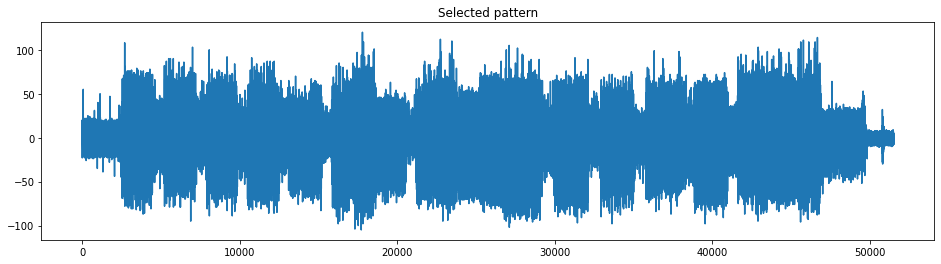

In [7]:
pattern = curves[0][4593500:4645000]
fig = plt.figure(figsize=[16,4])
ax = fig.gca()
ax.plot(pattern)
ax.set_title("Selected pattern")
plt.show()
np.save(os.path.join(tmp_directory,'raw_outer_iteration_pattern.npy'),pattern)

# Signal processing

However, this pattern is very large and computing cross-correlation on the full trace will be time consumming.
The shape of the pattern is similar to series of bursts in a radio signal and the position and length of these bursts seems to be a relevant characteristic to look at.

We thus can try to restrict this signal to its shape. This can be done by applying a filter on its envelop as shown below.

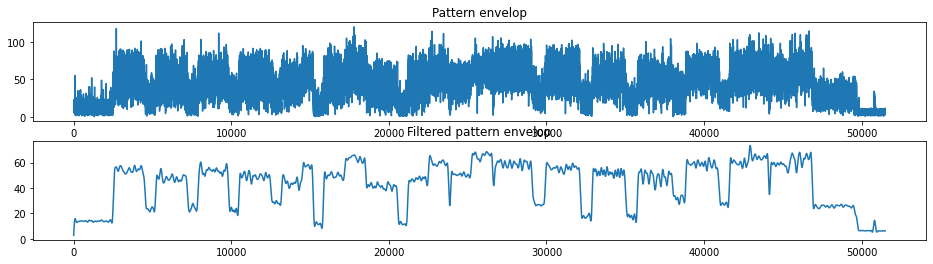

In [8]:
env_pattern = np.abs(hilbert(pattern))
sos = butter(4, 0.01, output='sos')
proc_pattern = sosfiltfilt(sos, env_pattern)
fig, axes = plt.subplots(2,1,figsize=(16,4))
axes[0].plot(env_pattern)
axes[0].set_title('Pattern envelop')
axes[1].plot(proc_pattern)
axes[1].set_title('Filtered pattern envelop')
plt.show()

We see that there is far too much samples to describe this pattern shape and thus propose to drastically decrease the correlation complexity by using decimation keeping a single point among 256.

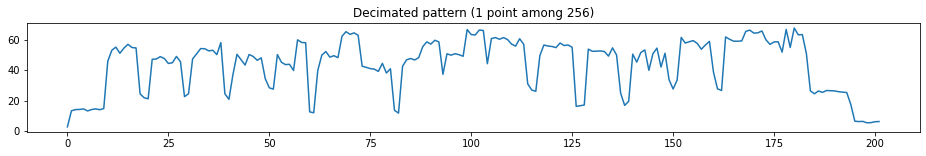

In [9]:
win_size = 256
dec_pattern = np.array([ proc_pattern[i] for i in range(0,len(proc_pattern),win_size) ])
fig = plt.figure(figsize=(16,2))
ax = fig.gca()
ax.plot(dec_pattern)
ax.set_title('Decimated pattern (1 point among {})'.format(win_size))
plt.show()

We see that the decimation does not decrease so much the shape of the pattern and thus we will use this pre-processing before computing cross-correlation.

The same has to be done on the curve for the curve and the pattern to be comparable.

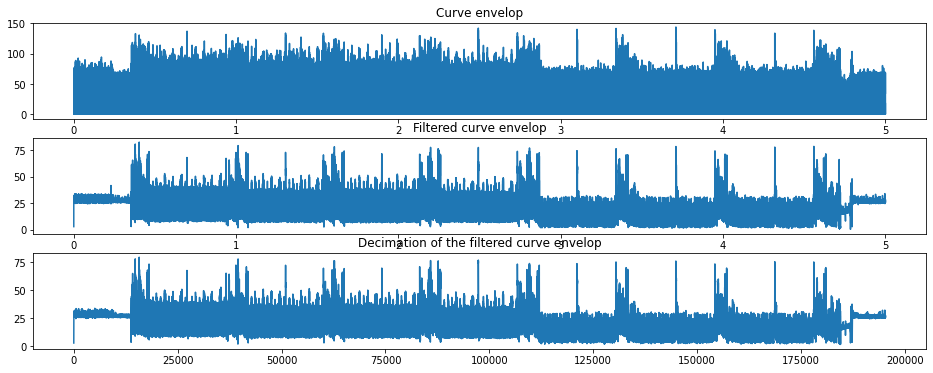

In [10]:
env_curve = np.abs(hilbert(curves[0]))
sos = butter(4, 0.01, output='sos')
proc_curve = sosfiltfilt(sos, env_curve)
dec_curve = np.array([ proc_curve[i] for i in range(0,len(proc_curve),win_size) ])
fig, axes = plt.subplots(3,1,figsize=(16,6))
axes[0].plot(env_curve)
axes[0].set_title('Curve envelop')
axes[1].plot(proc_curve)
axes[1].set_title('Filtered curve envelop')
axes[2].plot(dec_curve)
axes[2].set_title('Decimation of the filtered curve envelop')
plt.show()

# Cross-Correlation

Let us now take a look at the result of the cross-correlation between the pattern and the curve.
Due to our pre-processing step, the computation is a matter of seconds instead of minutes.

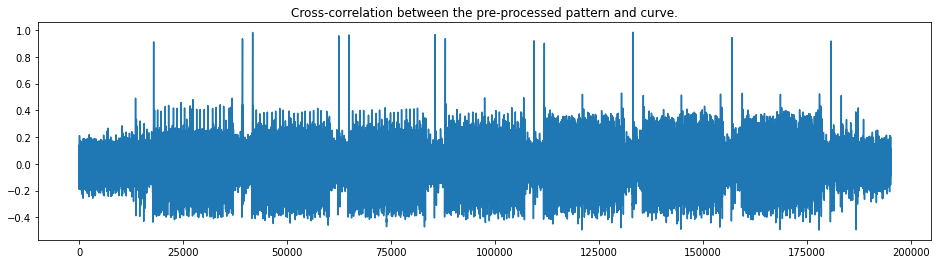

CPU times: user 16.3 s, sys: 100 ms, total: 16.4 s
Wall time: 16.2 s


In [11]:
%%time
pcc = pearson_xcorr(dec_curve,dec_pattern)
fig = plt.figure(figsize=[16,4])
ax = fig.gca()
ax.plot(pcc)
ax.set_title('Cross-correlation between the pre-processed pattern and curve.')
plt.show()

We clearly see high peaks as expected. However for the 4 iterations with non-zero syndrome the pattern seems to appear twice. Let us take a look at the corresponding neighbourhoods of those peaks to see which are the one actually corresponding to the beginning of the outer iteration.

In [12]:
detected_peaks = np.where(pcc>0.9)[0]

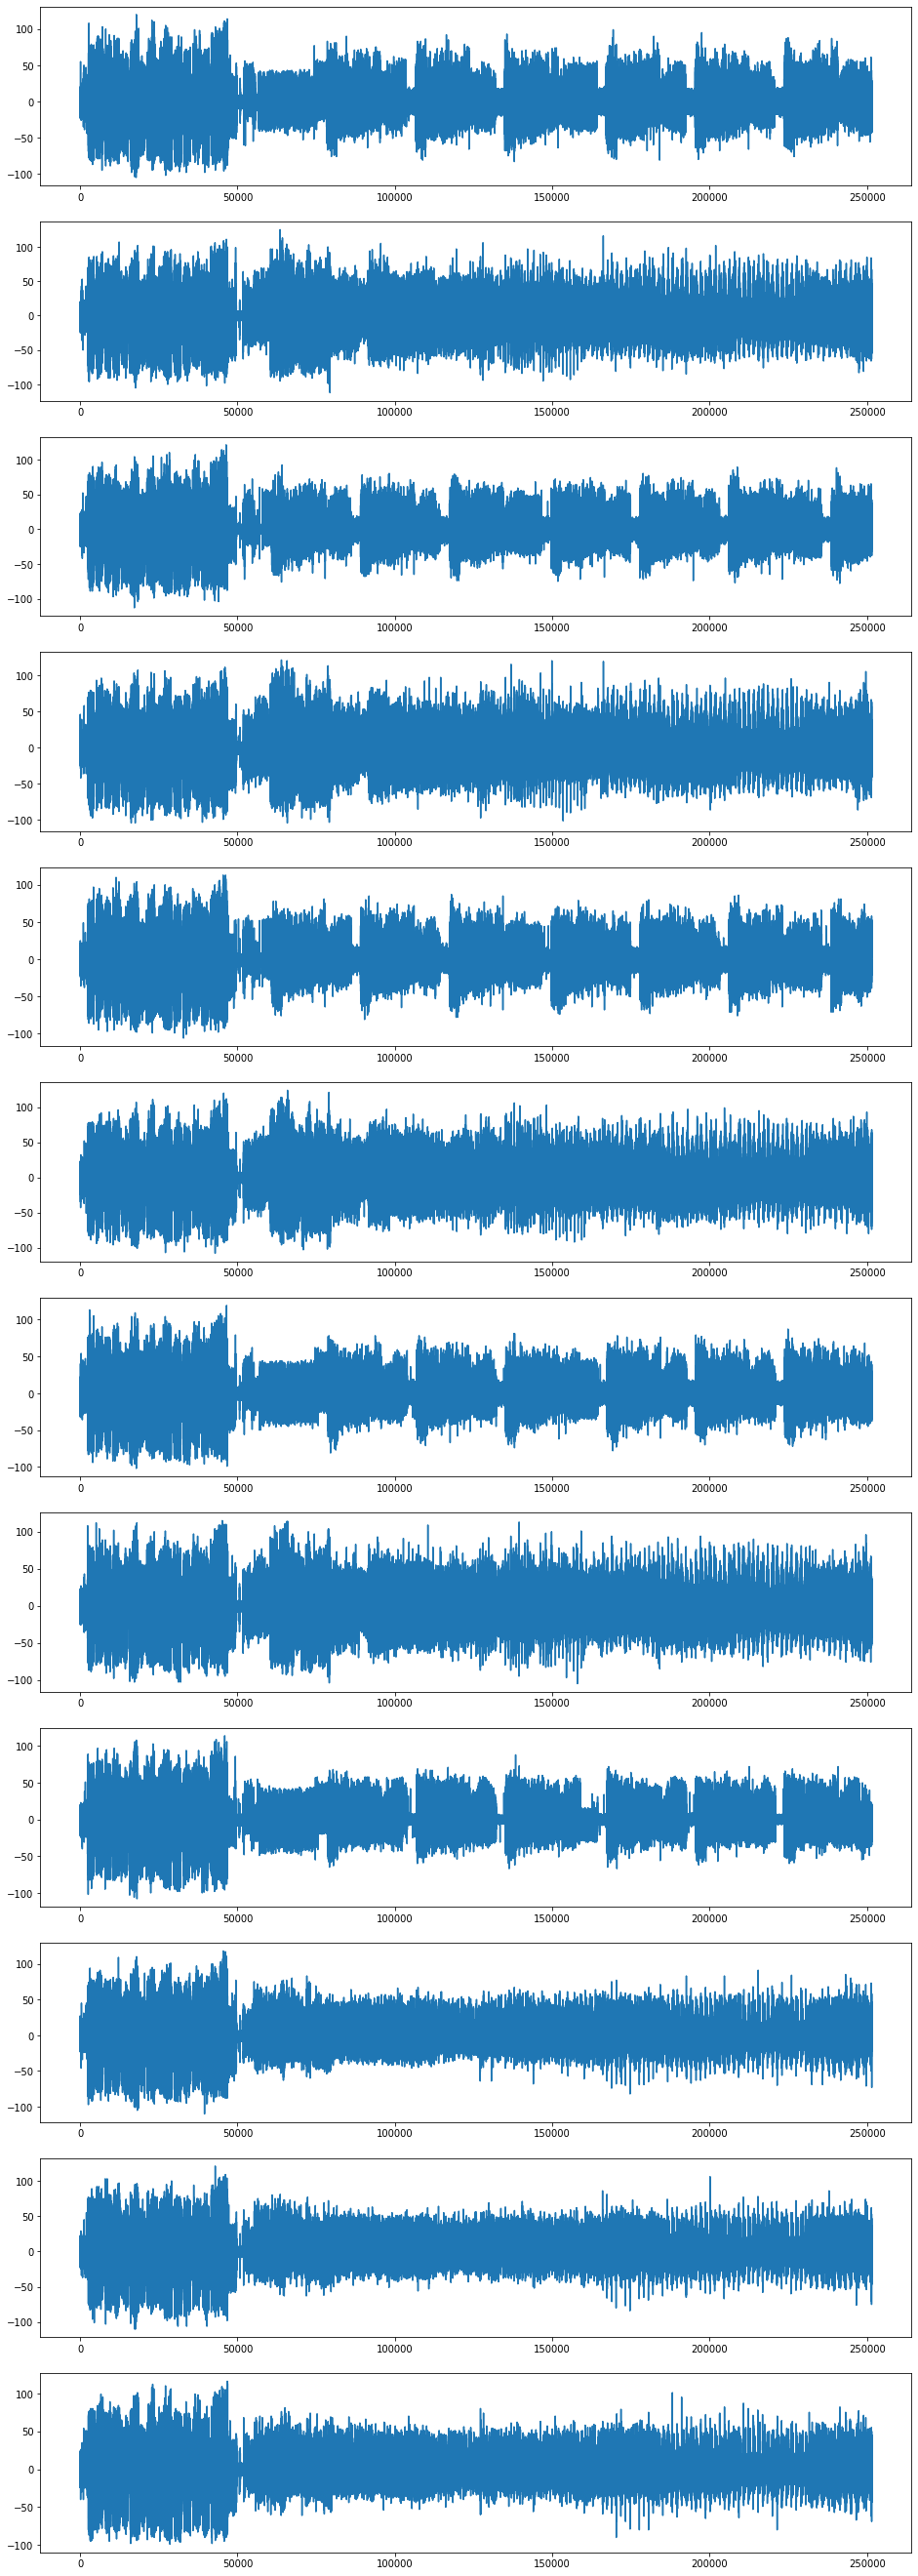

In [13]:
fig, axes = plt.subplots(len(detected_peaks),1,figsize=(16,4*len(detected_peaks)))
for i, p in enumerate(detected_peaks):
    axes[i].plot(curves[0][win_size*p:win_size*p+len(pattern)+200000])
plt.show()

It is clear now that the first of each couple of peaks is not the one we are looking for. In the case two peaks are separated by less than 2500 points (actually the gap is close to 2445) then we chose the second.

# Testing other curves

We have a technique working for the first curve based on a pattern taken from the first curve.
Let us now see if it also works for others.

In [14]:
sos = butter(4, 0.01, output='sos')
decimation = 256
def pre_proc(curve, win_size=decimation):
    """Apply our pre-processing to a curve with decimation parapeterized by `win_size` parameter."""
    env_curve = np.abs(hilbert(curve))
    proc_curve = sosfiltfilt(sos, env_curve)
    dec_curve = np.array([ proc_curve[i] for i in range(0,len(proc_curve),win_size) ])
    return dec_curve

def detect_peaks(correlation, threshold=0.85, min_gap=2500, keep='max'):
    """Detects peaks in a correlation result ensuring that at least `mean_gap` samples separates the peaks.
       If `keep` is set to 'max' then the point corresponding to the maximum correlation is kept over an interval
       of samples above the threshold."""
    detected_peaks = np.where(correlation>threshold)[0]
    if len(detected_peaks) == 0:
        return []
    else:
        res = [detected_peaks[0]]
        current_max = correlation[res[0]]
        for p in detected_peaks[1:]:
            if (p-res[-1]) > min_gap:
                res.append(p)
                current_max = correlation[p]
            elif keep == 'max' and correlation[p] > current_max:
                res[-1] = p
                current_max = correlation[p]
    return res

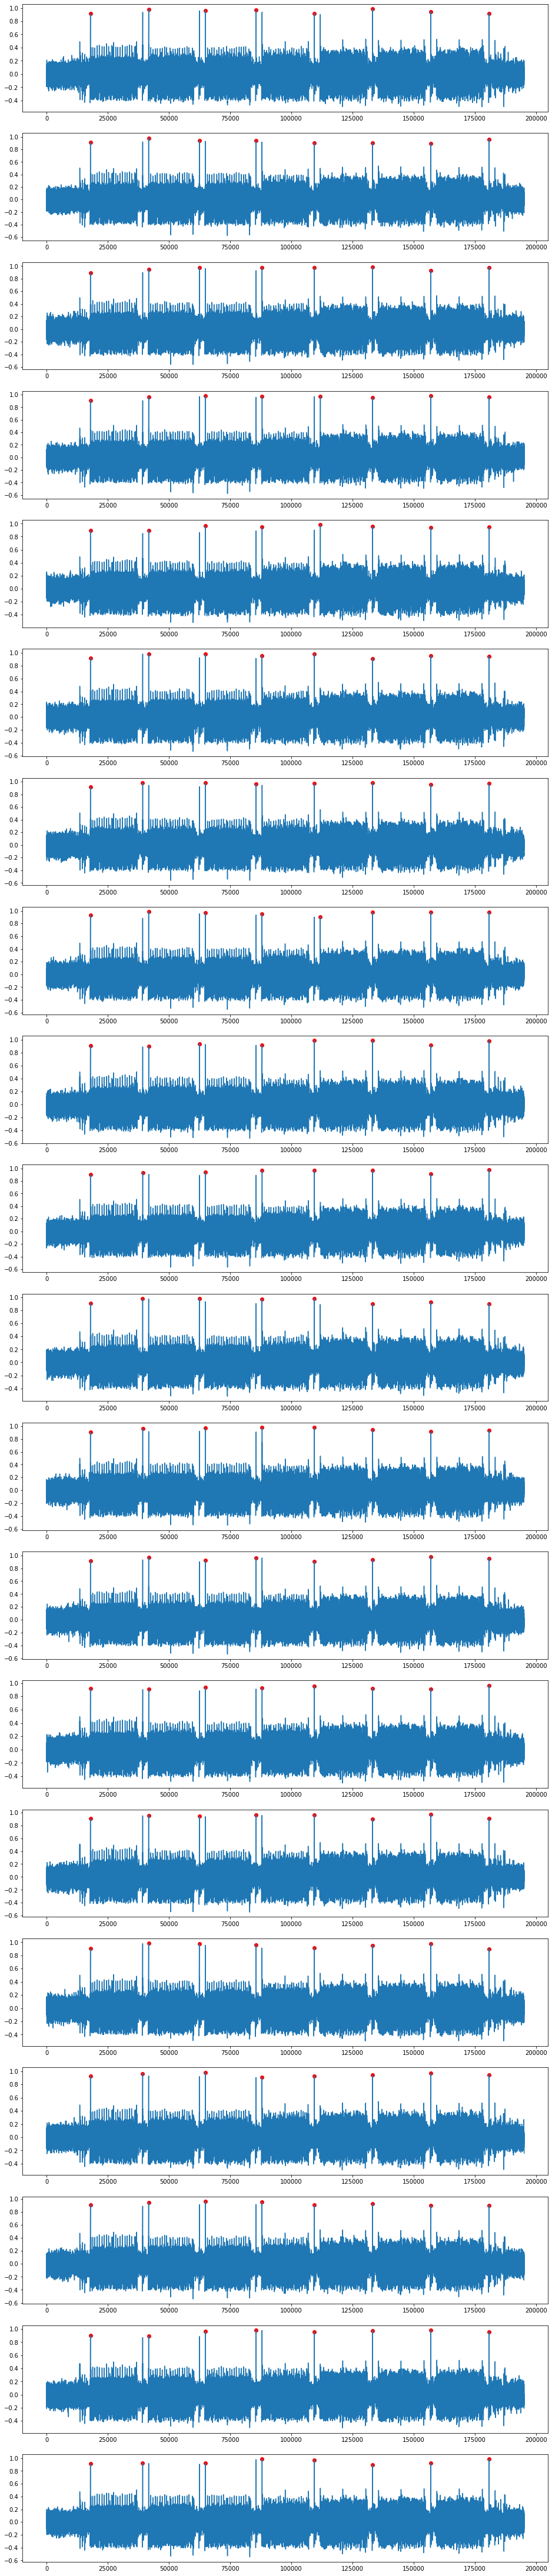

In [15]:
outer_iterations_bounds = []
fig, axes = plt.subplots(len(curves),1,figsize=(16,4*len(curves)))
for i, curve in enumerate(curves):
    pcc = pearson_xcorr(pre_proc(curve),dec_pattern)
    res = detect_peaks(pcc)
    outer_iterations_bounds.append(res)
    axes[i].plot(pcc)
    axes[i].scatter(res,[pcc[r] for r in res],color='red')
plt.show()
np.save(os.path.join(tmp_directory,'outer_iterations_bounds.npy'),decimation*np.array(outer_iterations_bounds))